In [228]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, font='Arial')

import warnings
warnings.filterwarnings('ignore')

## What is Text Summarization in NLP?

>"Automatic text summarization is the task of producing a concise and fluent summary while preserving key information content and overall meaning"

There are broadly two different approaches that are used for text summarization:

* Extractive summarization
* Abstractive summarization
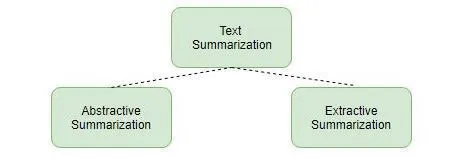

## Extractive Summarization
**We identify the important sentences or phrases from the original text and extract only those from the text.** Those extracted sentences would be our summary:
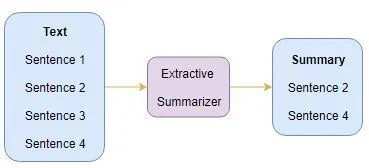

## TextRank algorithm
Share similarities with the PageRank algorithm

* In place of web pages, we use sentences
* Similarity between any two sentences is used as an equivalent to the web page transition probability
* The similarity scores are stored in a square matrix, similar to the matrix M used for PageRank.

#### TextRank is an extractive and unsupervised summarization technique
A look at the flow of the TextRank algorithm:
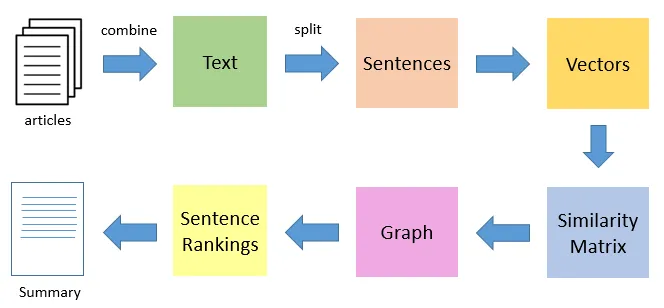

### Steps of TextRank

* Split the text into individual sentences
* Find vector representation (word embeddings) for each and every sentence
* Calculate similarity between sentence vectors and stored in a matrix
* The similarity matrix is then converted into a graph, with sentences as vertices and similarity scores as edges, for sentence rank calculation
* Finally, a certain number of top-ranked sentences form the final summary

In [151]:
df = pd.read_csv('../data/product_merged.csv', usecols=['Complaint ID', 'Product', 'Issue',
                                                       'Consumer complaint narrative'])

In [159]:
def tokenize_sentences(texts):
    """Use NLTK to split the complaint text into sentences. 
    Note that we read in the all the complaint texts as a list."""
    special = re.compile(r'[\r|\n|\n\r]+') # Remove all the newline characters
    sentences = [sent_tokenize(special.sub(' ', doc)) for doc in texts] 

    return sentences

In [160]:
sentences = tokenize_sentences(df['Consumer complaint narrative'])

In [ ]:
sentences[0]

### Text Preprocessing
Make the text as clean as possible - use regex and spacy to clean and preprocess, including removing stopwords. Given the size of our corpus, this may take a while.

In [162]:
# Remove all weblinks, the XXX anonymiser and any non-alphabetic characters (except spaces)
special = re.compile(r'http\S+|www\S+|[^a-zA-Z ]+|xx+')
docs = [[' '.join(special.sub('', doc.lower()).split()) for doc in s] for s in sentences] 

import spacy
nlp = spacy.load("en_core_web_sm")

clean_sentences = []
for s in docs:
    tokenized = []
    for doc in nlp.pipe(s, disable=['tagger', 'parser', 'ner']):
        tokenized.append(" ".join(token.text for token in doc 
                               if not token.is_stop and not token.is_space)) 
    clean_sentences.append(tokenized)  

## Example:
Text split into sentences: - unfortunately you can see the sentence tokenizer isn't working perfectly - the XXXXs don't really help either.

In [ ]:
idx = 168
sentences[idx]

In [ ]:
clean_sentences[idx]

## Vector Representation of Sentences
### Embed the sentences:  GloVe (Global Vectors) embeddings
Here we use the pre-trained **Wikipedia2014 + Gigaword 5** GloVe vectors. 
<img src="../figures/glove.png" width="480">
Original paper: http://www.aclweb.org/anthology/D14-1162

We now have word vectors for 400,000 different terms stored in the dictionary of word embeddings.

Fetch vectors (each of size 100 elements) for the words in a sentence and then take the mean of those vectors to create a consolidated vector for the sentence.


In [23]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

# Extract word vectors
word_embeddings = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

In [165]:
def gen_sent_vectors(clean_sentences):
    """
    Generate sentence vectors using word embeddings.
    """
    sentence_vectors = []
    for i in clean_sentences:
        if len(i) != 0:
            v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
        else:
            v = np.zeros((100,))
        sentence_vectors.append(v)
    return sentence_vectors

In [ ]:
sent_vectors = gen_sent_vectors(clean_sentences[idx])
f, ax = plt.subplots(figsize=(14, 6))
ax = sns.heatmap(sent_vectors, cmap='Greens')

### Similarity Matrix Preparation
The next step is to find similarities between the sentences, and we will use the cosine similarity approach. Let's create an empty similarity matrix and populate it with cosine similarities of the sentences. In case you've forgotten, cosine similarity is defined by the following:

$$
{\displaystyle {\text{similarity}}=\cos(\theta )={\mathbf {v}_1 \cdot \mathbf {v}_2  \over \|\mathbf {v}_1 \|\|\mathbf {v}_2 \|}={\frac {\sum \limits _{i=1}^{n}{v_{1i}v_{2i}}}{{\sqrt {\sum \limits _{i=1}^{n}{v_{1i}^{2}}}}{\sqrt {\sum \limits _{i=1}^{n}{v_{2i}^{2}}}}}},}
$$

Let's first define a zero matrix of dimensions (n * n), and initialize it with cosine similarity scores of the sentences. Here **n** is the number of sentences.

In [166]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity_matrix(one_complaint, sentence_vectors):
    """
    Compute similarity matrix between sentences within one complaint.
    """
    sim_mat = np.zeros([len(one_complaint), len(one_complaint)])
    for i in range(len(one_complaint)):
        for j in range(len(one_complaint)):
            if i != j:
                sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1, 100),
                                                 sentence_vectors[j].reshape(1, 100))[0, 0]
    return sim_mat

In [ ]:
similarity_mat = compute_similarity_matrix(sentences[idx], sent_vectors)
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(similarity_mat, cmap='Reds')
ax.set_title('Similarity between sentence embeddings');

### Applying PageRank Algorithm
* Convert the similarity matrix into a graph using networkX:

    - Nodes of the graph will represent the sentences
    - Edges will represent the similarity scores between the sentences
    
Note this is a complete graph!
    
* Apply the PageRank algorithm to arrive at the sentence ranking

In [ ]:
G = nx.from_numpy_array(similarity_mat)
nx.draw_circular(G)

In [217]:
import networkx as nx

def rank_sentences(sim_mat, one_complaint):
    """
    Compute the PageRank value for each of the sentence vectors and sort them
    to return in descending order.
    """
    nx_graph = nx.from_numpy_array(sim_mat)
    try: # Note that PageRank is not guaranteed to converge, hence return the same sentences
        scores = nx.pagerank(nx_graph, max_iter=100)
    except Exception:
        scores = np.zeros(len(one_complaint))
    
    ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(one_complaint)), reverse=True)
    return ranked_sentences

In [ ]:
rank_sentences(similarity_mat, sentences[idx])

### Run algorithm to get the n most important sentences in a complaint

In [245]:
def gen_top_n_sentences(one_complaint, clean_sentences, maxlen=5):
    """
    Get the top N most relevant sentences of each of the complaints.
    This is done by using the TextRank algorithm, in the same spirit
    as the PageRank algorithm, except the nodes of the graph are 
    sentences instead of webpages.
    
    If the number of sentences in the complaint is less than maxlen
    then we just return the sentence.
    
    Args:
        one_complaint - list of sentences in a complaint
        clean_sentences - list of cleaned tokens used to generate the 
            sentence vectors
        maxlen - int, maximum number of sentences to return
        
    Return:
        String - condensed complaint text
    """
    if len(one_complaint) < maxlen:
        condensed = ' '.join(one_complaint)
    else:
        # Compute sentence vectors
        sentence_vectors = gen_sent_vectors(clean_sentences)
        
        # Calculate similarity matrix between vectors
        sim_mat = compute_similarity_matrix(one_complaint, sentence_vectors)
        
        # Calculate the PageRank score of the sentences and return in reverse order
        ranked_sentences = rank_sentences(sim_mat, one_complaint)
        
        # Only get the top N sentences
        condensed_sent = [sent[1] for i, sent in enumerate(ranked_sentences) if i < maxlen]
        
        # Join with the anonymisers removed.
        condensed = ' '.join(re.sub('xx\\S+|XX\\S+', ' ', ' '.join(condensed_sent)).split())
    return condensed

Save the split complaint text, cleaned sentences and word embeddings so can run this on multiple cores

In [170]:
import pickle
data = {'sentences': sentences, 'clean_sentences': clean_sentences, 'embeddings': word_embeddings}
with open('../output/sentences.pickle', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
idx = 1970
print(df.iloc[idx]['Product'])
print(df.iloc[idx]['Issue'])
print()
condensed_1 = gen_top_n_sentences(sentences[idx], clean_sentences[idx])
print(condensed_1)
print()
print(sentences[idx])

In [173]:
with open('../output/summary_1.txt', 'w') as f:
    for idx in range(100000):
        if idx % 200 == 0:
            print(idx)
        summary = gen_top_n_sentences(sentences[idx], clean_sentences[idx])
        f.write('{}\n'.format(summary))

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
10200
10400
10600
10800
11000
11200
11400
11600
11800
12000
12200
12400
12600
12800
13000
13200
13400
13600
13800
14000
14200
14400
14600
14800
15000
15200
15400
15600
15800
16000
16200
16400
16600
16800
17000
17200
17400
17600
17800
18000
18200
18400
18600
18800
19000
19200
19400
19600
19800
20000
20200
20400
20600
20800
21000
21200
21400
21600
21800
22000
22200
22400
22600
22800
23000
23200
23400
23600
23800
24000
24200
24400
24600
24800
25000
25200
25400
25600
25800
26000
26200
26400
26600
26800
27000
27200
27400
27600
27800
28000
28200
28400
28600
28800
29000
29200
29400
29600
29800
30000
30200
30400
30600
30800
31000
31200
31400
31600
31800
32000
32200
32400
32600
32800
33000
33200
33400
33600
33800
34000
34200
34400
34600
34800
35000
3

This is massively slow - but we are dealing with > 400,000 complaints here, and we are looping through them.